In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from scipy.signal import savgol_filter
from scipy.sparse.linalg import spsolve
from scipy import sparse
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("✓ Libraries imported successfully!")
print(f"Working directory: {os.getcwd()}")

✓ Libraries imported successfully!
Working directory: /content


## 1. Load SERS Spectral Data

Loading the  Cr6+ SERS data from text files.

In [36]:
# Define data directory
data_dir = Path(r'/content/drive/MyDrive/Cr')

# Define concentration classes
cr_files = [
    '00_Control.txt',
    '01_0.68 pM.txt',
    '02_6.8 pM.txt',
    '03_68 pM.txt',
    '04_0.68 nM.txt',
    '05_6.8 nM.txt',
    '06_68 nM.txt',
    '07_0.68 uM.txt',
    '08_6.8 uM.txt',
    '09_68 uM.txt'
]

cr_concentrations = [
    'Control',
    '0.68 pM',
    '6.8 pM',
    '68 pM',
    '0.68 nM',
    '6.8 nM',
    '68 nM',
    '0.68 µM',
    '6.8 µM',
    '68 µM'
]

print(f"Number of concentration classes: {len(cr_files)}")
print(f"\nFiles to load:")
for i, (file, conc) in enumerate(zip(cr_files, cr_concentrations)):
    print(f"  Class {i}: {conc:15s} - {file}")

Number of concentration classes: 10

Files to load:
  Class 0: Control         - 00_Control.txt
  Class 1: 0.68 pM         - 01_0.68 pM.txt
  Class 2: 6.8 pM          - 02_6.8 pM.txt
  Class 3: 68 pM           - 03_68 pM.txt
  Class 4: 0.68 nM         - 04_0.68 nM.txt
  Class 5: 6.8 nM          - 05_6.8 nM.txt
  Class 6: 68 nM           - 06_68 nM.txt
  Class 7: 0.68 µM         - 07_0.68 uM.txt
  Class 8: 6.8 µM          - 08_6.8 uM.txt
  Class 9: 68 µM           - 09_68 uM.txt


In [37]:

def load_sers_data(filepath, max_spectra=None):
    """
    Load SERS spectral data from text file.

    Parameters:
    -----------
    filepath : str or Path
        Path to the data file
    max_spectra : int, optional
        Maximum number of spectra to load (for memory management)

    Returns:
    --------
    spectra : ndarray
        Array of SERS spectra (n_spectra, n_wavelengths)
    wavenumbers : ndarray
        Wavenumber values
    """
    print(f"Loading: {Path(filepath).name}...", end=' ')

    # Load data
    data = np.loadtxt(filepath)

    # Extract wavenumbers (column 3, index 2) and intensities (column 4, index 3)
    wavenumbers = data[:, 2]
    intensities = data[:, 3]

    # Find unique wavenumbers to determine spectrum length
    unique_wn = np.unique(wavenumbers)
    n_points = len(unique_wn)
    n_spectra = len(data) // n_points

    # Reshape into spectra matrix
    if max_spectra is not None and n_spectra > max_spectra:
        n_spectra = max_spectra

    spectra = intensities[:n_spectra * n_points].reshape(n_spectra, n_points)

    print(f"✓ Loaded {n_spectra} spectra with {n_points} points each")

    return spectra, unique_wn

print("Data loading function defined.")

Data loading function defined.


In [38]:
# # Load all SERS data
# # For memory efficiency, we'll load 1200 spectra per class (as in the paper)
# # Control class will have more samples (simulating the paper's approach)

# print("Loading SERS spectral data...\n")

# X_list = []
# y_list = []
# wavenumbers = None

# for class_idx, (filename, conc_name) in enumerate(zip(cr_files, cr_concentrations)):
#     filepath = data_dir / filename

#     # Control class gets more samples (as per paper methodology)
#     max_spec = 8000 if class_idx == 0 else 1200

#     spectra, wn = load_sers_data(filepath, max_spectra=max_spec)

#     if wavenumbers is None:
#         wavenumbers = wn

#     X_list.append(spectra)
#     y_list.extend([class_idx] * len(spectra))

# # Combine all data
# X = np.vstack(X_list)
# y = np.array(y_list)

# print(f"\n{'='*60}")
# print(f"DATASET SUMMARY")
# print(f"{'='*60}")
# print(f"Total spectra: {X.shape[0]:,}")
# print(f"Spectral points per spectrum: {X.shape[1]:,}")
# print(f"Wavenumber range: {wavenumbers.min():.2f} - {wavenumbers.max():.2f} cm⁻¹")
# print(f"Number of classes: {len(np.unique(y))}")
# print(f"\nClass distribution:")
# for i, conc in enumerate(cr_concentrations):
#     count = np.sum(y == i)
#     print(f"  {conc:15s}: {count:5d} spectra")
# print(f"{'='*60}")
# Load all SERS data
# For memory efficiency, we'll load 1200 spectra per class (as in the paper)
# Control class will have more samples (simulating the paper's approach)

print("Loading SERS spectral data...\n")

# Fixed number of spectral points (as per the paper methodology)
N_POINTS = 1011

def load_sers_data_robust(filepath, n_points=1011, max_spectra=None):
    """
    Load SERS spectral data from text file with robust handling of inconsistent columns.

    Parameters:
    -----------
    filepath : str or Path
        Path to the data file
    n_points : int
        Number of spectral points per spectrum (default 1011)
    max_spectra : int, optional
        Maximum number of spectra to load (for memory management)

    Returns:
    --------
    spectra : ndarray
        Array of SERS spectra (n_spectra, n_points)
    wavenumbers : ndarray
        Wavenumber values (first n_points unique values)
    """
    print(f"Loading: {Path(filepath).name}...", end=' ')

    # Read file line by line and filter for lines with 4 columns
    valid_rows = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 4:
                try:
                    row = [float(parts[0]), float(parts[1]), float(parts[2]), float(parts[3])]
                    valid_rows.append(row)
                except ValueError:
                    continue

    data = np.array(valid_rows)

    # Extract wavenumbers (column 3, index 2) and intensities (column 4, index 3)
    wavenumbers_all = data[:, 2]
    intensities = data[:, 3]

    # Calculate number of complete spectra
    n_spectra = len(intensities) // n_points

    # Limit spectra if requested
    if max_spectra is not None and n_spectra > max_spectra:
        n_spectra = max_spectra

    # Reshape into spectra matrix with fixed n_points
    spectra = intensities[:n_spectra * n_points].reshape(n_spectra, n_points)

    # Get wavenumbers from first spectrum
    wavenumbers = wavenumbers_all[:n_points]

    print(f"Loaded {n_spectra} spectra with {n_points} points each")

    return spectra, wavenumbers

X_list = []
y_list = []
wavenumbers = None

for class_idx, (filename, conc_name) in enumerate(zip(cr_files, cr_concentrations)):
    filepath = data_dir / filename

    # Control class gets more samples (as per paper methodology)
    max_spec = 8000 if class_idx == 0 else 1200

    spectra, wn = load_sers_data_robust(filepath, n_points=N_POINTS, max_spectra=max_spec)

    if wavenumbers is None:
        wavenumbers = wn

    X_list.append(spectra)
    y_list.extend([class_idx] * len(spectra))

# Combine all data
X = np.vstack(X_list)
y = np.array(y_list)

print(f"\n{'='*60}")
print(f"DATASET SUMMARY")
print(f"{'='*60}")
print(f"Total spectra: {X.shape[0]:,}")
print(f"Spectral points per spectrum: {X.shape[1]:,}")
print(f"Wavenumber range: {wavenumbers.min():.2f} - {wavenumbers.max():.2f} cm^-1")
print(f"Number of classes: {len(np.unique(y))}")
print(f"\nClass distribution:")
for i, conc in enumerate(cr_concentrations):
    count = np.sum(y == i)
    print(f"  {conc:15s}: {count:5d} spectra")
print(f"{'='*60}")

Loading SERS spectral data...

Loading: 00_Control.txt... Loaded 8000 spectra with 1011 points each
Loading: 01_0.68 pM.txt... Loaded 1200 spectra with 1011 points each
Loading: 02_6.8 pM.txt... Loaded 1200 spectra with 1011 points each
Loading: 03_68 pM.txt... Loaded 1200 spectra with 1011 points each
Loading: 04_0.68 nM.txt... Loaded 1200 spectra with 1011 points each
Loading: 05_6.8 nM.txt... Loaded 1200 spectra with 1011 points each
Loading: 06_68 nM.txt... Loaded 1200 spectra with 1011 points each
Loading: 07_0.68 uM.txt... Loaded 1200 spectra with 1011 points each
Loading: 08_6.8 uM.txt... Loaded 1200 spectra with 1011 points each
Loading: 09_68 uM.txt... Loaded 1200 spectra with 1011 points each

DATASET SUMMARY
Total spectra: 18,800
Spectral points per spectrum: 1,011
Wavenumber range: 508.88 - 1640.65 cm^-1
Number of classes: 10

Class distribution:
  Control        :  8000 spectra
  0.68 pM        :  1200 spectra
  6.8 pM         :  1200 spectra
  68 pM          :  1200 spect

## 2. Data Visualization

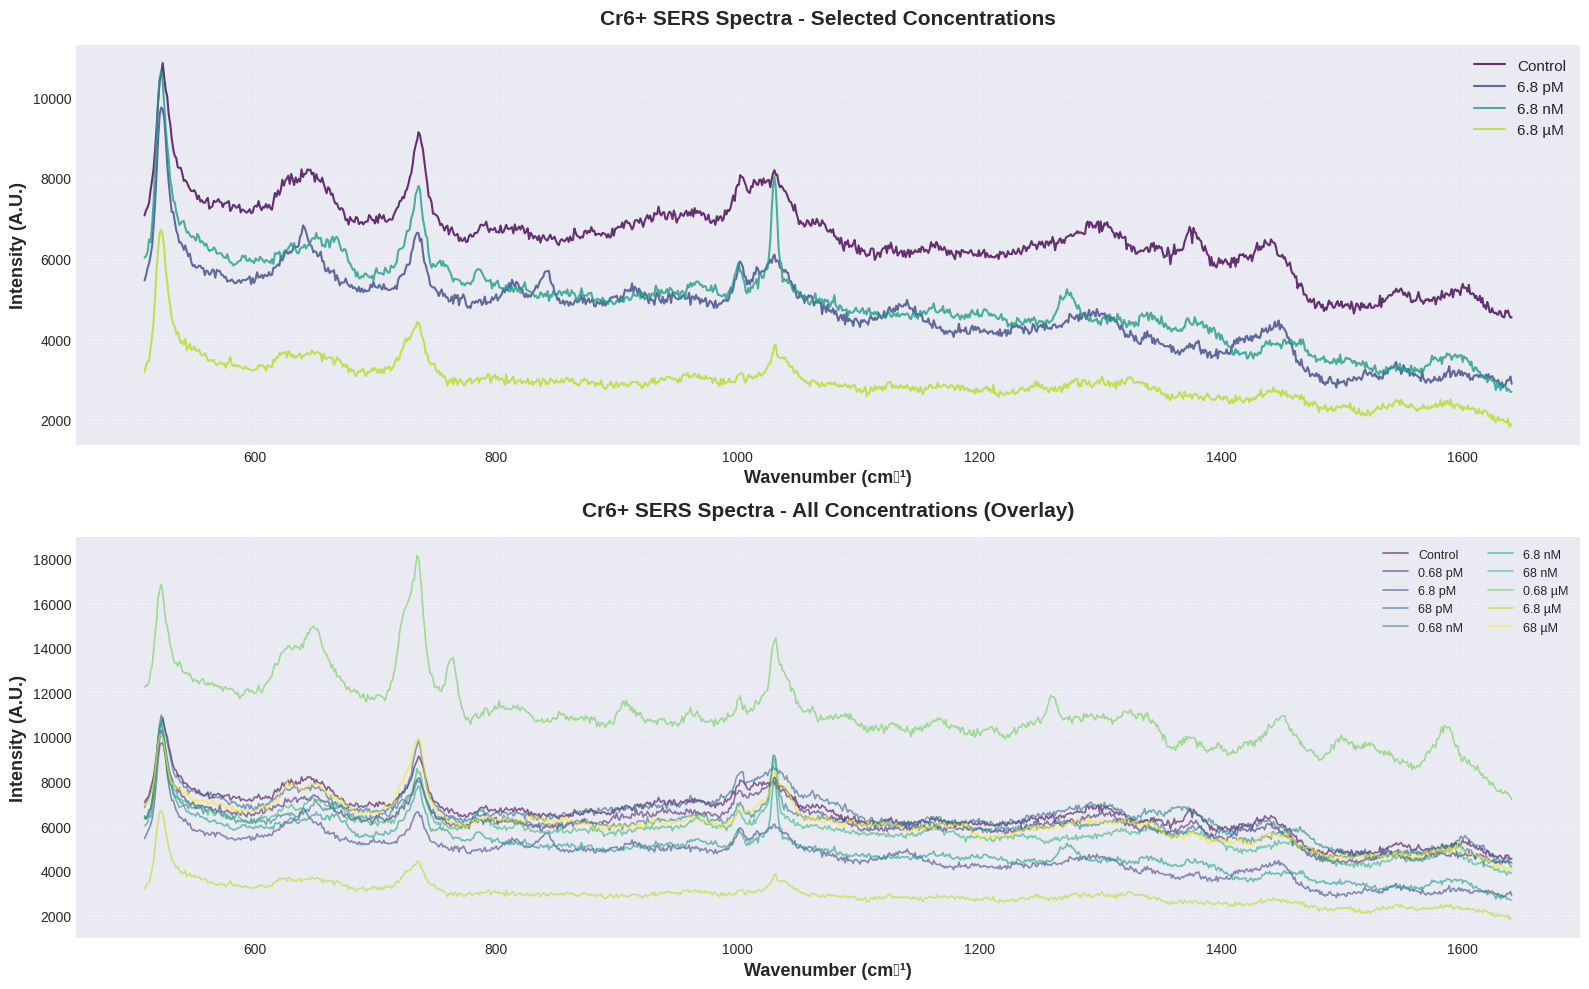

In [39]:
# Plot sample spectra for different concentrations
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Selected concentrations
colors = plt.cm.viridis(np.linspace(0, 1, len(cr_concentrations)))
for i in [0, 2, 5, 8]:  # Control, 6.8 pM, 6.8 nM, 6.8 µM
    idx = np.where(y == i)[0][0]
    axes[0].plot(wavenumbers, X[idx], label=cr_concentrations[i],
                color=colors[i], alpha=0.8, linewidth=1.5)

axes[0].set_xlabel('Wavenumber (cm⁻¹)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Intensity (A.U.)', fontsize=13, fontweight='bold')
axes[0].set_title('Cr6+ SERS Spectra - Selected Concentrations',
                  fontsize=15, fontweight='bold', pad=15)
axes[0].legend(fontsize=11, loc='best')
axes[0].grid(True, alpha=0.3, linestyle='--')

# Plot 2: All concentrations (overlay)
for i in range(len(cr_concentrations)):
    idx = np.where(y == i)[0][0]
    axes[1].plot(wavenumbers, X[idx], label=cr_concentrations[i],
                color=colors[i], alpha=0.6, linewidth=1.2)

axes[1].set_xlabel('Wavenumber (cm⁻¹)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Intensity (A.U.)', fontsize=13, fontweight='bold')
axes[1].set_title('Cr6+ SERS Spectra - All Concentrations (Overlay)',
                  fontsize=15, fontweight='bold', pad=15)
axes[1].legend(fontsize=9, loc='best', ncol=2)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

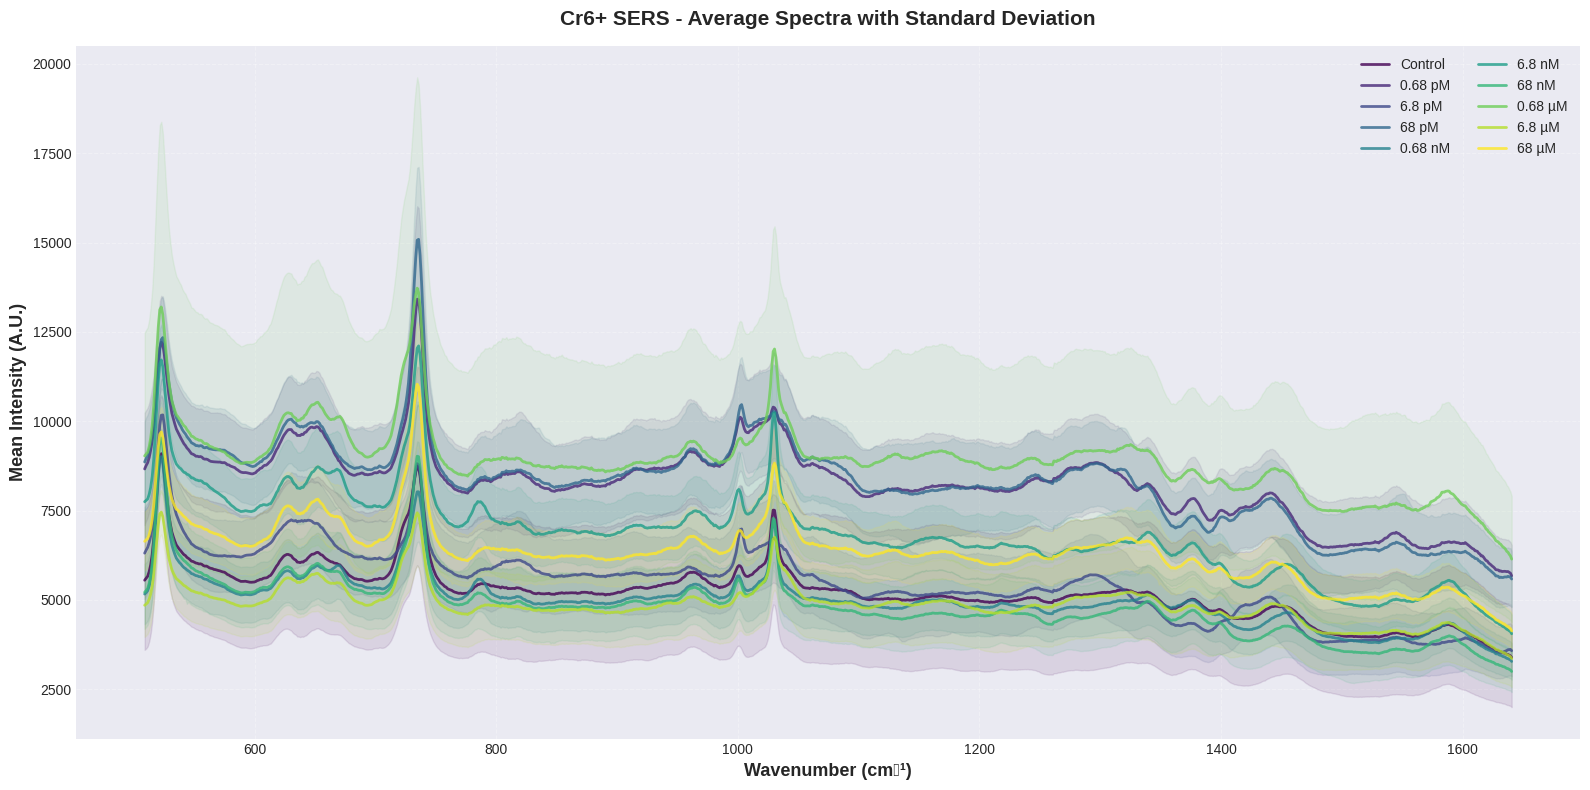

In [40]:
# Plot average spectra per concentration
fig, ax = plt.subplots(figsize=(16, 8))

for i, conc in enumerate(cr_concentrations):
    class_spectra = X[y == i]
    mean_spectrum = np.mean(class_spectra, axis=0)
    std_spectrum = np.std(class_spectra, axis=0)

    ax.plot(wavenumbers, mean_spectrum, label=conc,
           color=colors[i], linewidth=2, alpha=0.8)
    ax.fill_between(wavenumbers,
                    mean_spectrum - std_spectrum,
                    mean_spectrum + std_spectrum,
                    color=colors[i], alpha=0.1)

ax.set_xlabel('Wavenumber (cm⁻¹)', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean Intensity (A.U.)', fontsize=13, fontweight='bold')
ax.set_title('Cr6+ SERS - Average Spectra with Standard Deviation',
            fontsize=15, fontweight='bold', pad=15)
ax.legend(fontsize=10, loc='best', ncol=2)
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

Following the paper's methodology:
1. **Baseline correction** - Asymmetric Least Squares
2. **Smoothing** - Savitzky-Golay filter
3. **Normalization** - StandardScaler
4. **PCA** - Reduce to 22 components (capturing >93% variance)

In [41]:
def baseline_als(y, lam=1e6, p=0.01, niter=10):
    """
    Asymmetric Least Squares baseline correction

    Parameters:
    -----------
    y : array
        Input spectrum
    lam : float
        Smoothness parameter
    p : float
        Asymmetry parameter
    niter : int
        Number of iterations

    Returns:
    --------
    z : array
        Estimated baseline
    """
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

def preprocess_spectrum(spectrum, window_length=11, polyorder=3):
    """
    Preprocess a single SERS spectrum
    """
    # Baseline correction
    baseline = baseline_als(spectrum)
    corrected = spectrum - baseline

    # Smoothing with Savitzky-Golay filter
    smoothed = savgol_filter(corrected, window_length, polyorder)

    return smoothed

print("Preprocessing functions defined.")

Preprocessing functions defined.


In [42]:
# Apply preprocessing to all spectra
print("Applying preprocessing (baseline correction + smoothing)...")
print("This may take a few minutes...\n")

X_preprocessed = np.zeros_like(X)

# Process in batches to show progress
batch_size = 1000
n_batches = int(np.ceil(len(X) / batch_size))

for batch_idx in range(n_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(X))

    for i in range(start_idx, end_idx):
        X_preprocessed[i] = preprocess_spectrum(X[i])

    progress = (end_idx / len(X)) * 100
    print(f"  Progress: {progress:.1f}% ({end_idx}/{len(X)} spectra)")

print("\n✓ Preprocessing complete!")

Applying preprocessing (baseline correction + smoothing)...
This may take a few minutes...

  Progress: 5.3% (1000/18800 spectra)
  Progress: 10.6% (2000/18800 spectra)
  Progress: 16.0% (3000/18800 spectra)
  Progress: 21.3% (4000/18800 spectra)
  Progress: 26.6% (5000/18800 spectra)
  Progress: 31.9% (6000/18800 spectra)
  Progress: 37.2% (7000/18800 spectra)
  Progress: 42.6% (8000/18800 spectra)
  Progress: 47.9% (9000/18800 spectra)
  Progress: 53.2% (10000/18800 spectra)
  Progress: 58.5% (11000/18800 spectra)
  Progress: 63.8% (12000/18800 spectra)
  Progress: 69.1% (13000/18800 spectra)
  Progress: 74.5% (14000/18800 spectra)
  Progress: 79.8% (15000/18800 spectra)
  Progress: 85.1% (16000/18800 spectra)
  Progress: 90.4% (17000/18800 spectra)
  Progress: 95.7% (18000/18800 spectra)
  Progress: 100.0% (18800/18800 spectra)

✓ Preprocessing complete!


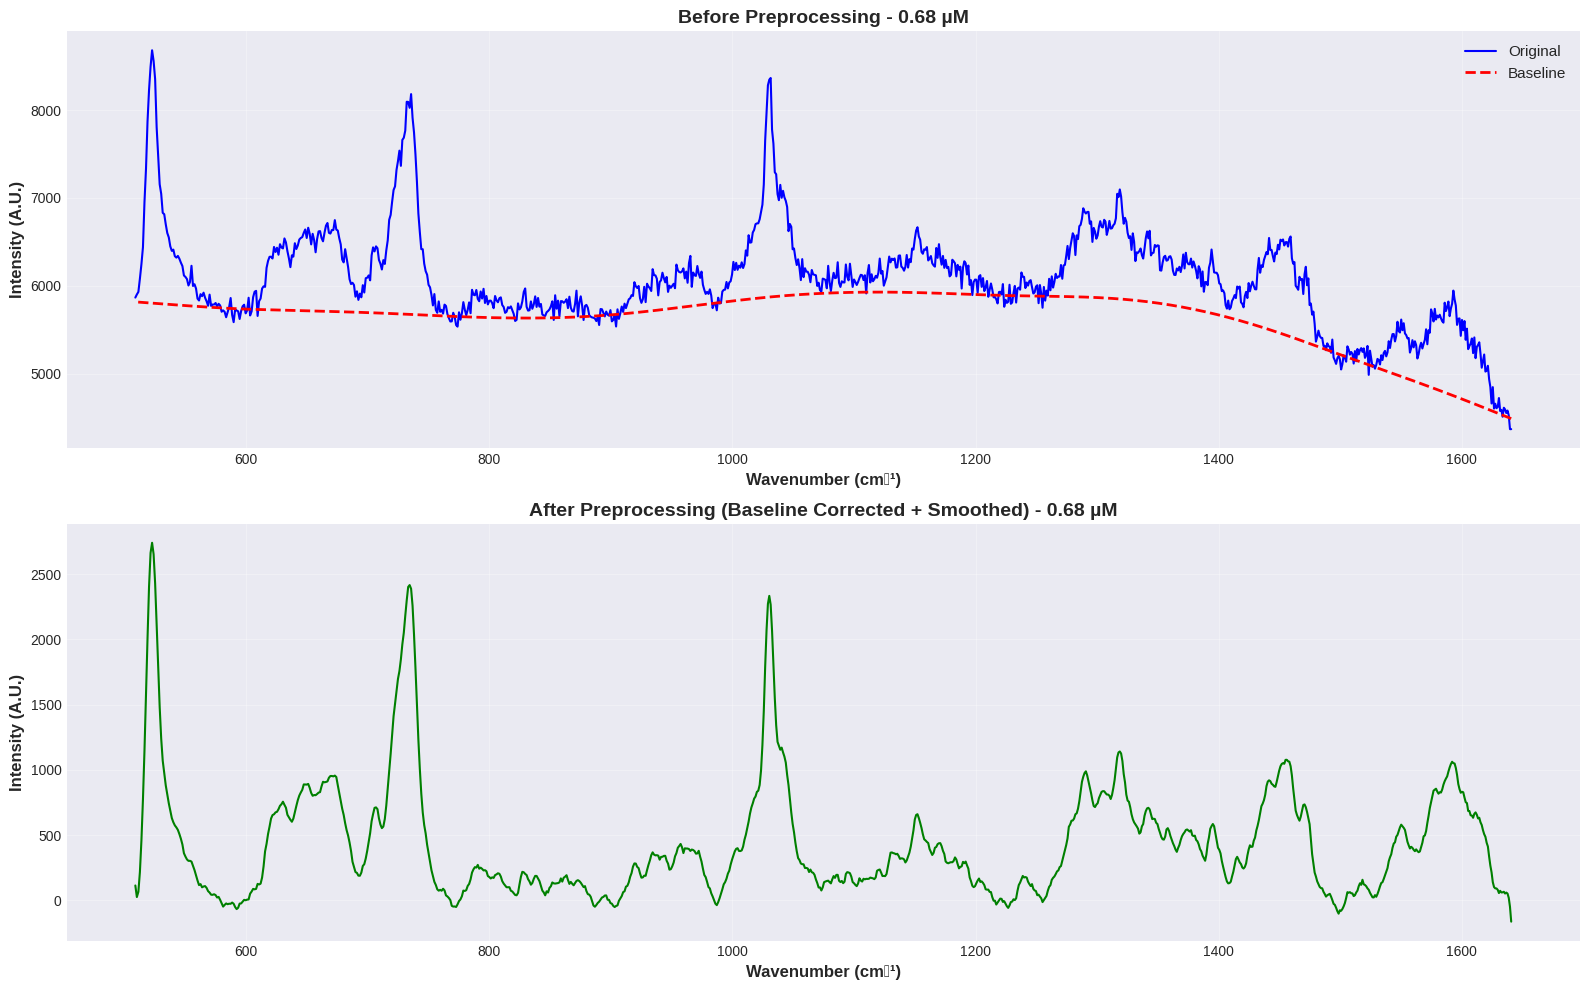

In [43]:
# Visualize effect of preprocessing
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Select a random spectrum
idx = np.random.randint(0, len(X))
class_label = cr_concentrations[y[idx]]

# Before preprocessing
axes[0].plot(wavenumbers, X[idx], 'b-', linewidth=1.5, label='Original')
baseline = baseline_als(X[idx])
axes[0].plot(wavenumbers, baseline, 'r--', linewidth=2, label='Baseline')
axes[0].set_xlabel('Wavenumber (cm⁻¹)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Intensity (A.U.)', fontsize=12, fontweight='bold')
axes[0].set_title(f'Before Preprocessing - {class_label}', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# After preprocessing
axes[1].plot(wavenumbers, X_preprocessed[idx], 'g-', linewidth=1.5)
axes[1].set_xlabel('Wavenumber (cm⁻¹)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Intensity (A.U.)', fontsize=12, fontweight='bold')
axes[1].set_title(f'After Preprocessing (Baseline Corrected + Smoothed) - {class_label}',
                 fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [44]:
# Normalization and PCA
print("Applying normalization and PCA...\n")

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_preprocessed)

# PCA for dimensionality reduction
n_components = 22  # As per the paper
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

explained_variance = np.sum(pca.explained_variance_ratio_) * 100

print(f"✓ Normalization complete")
print(f"✓ PCA complete: {n_components} components")
print(f"  Explained variance: {explained_variance:.2f}%")
print(f"\nReduced data shape: {X_pca.shape}")

Applying normalization and PCA...

✓ Normalization complete
✓ PCA complete: 22 components
  Explained variance: 74.26%

Reduced data shape: (18800, 22)


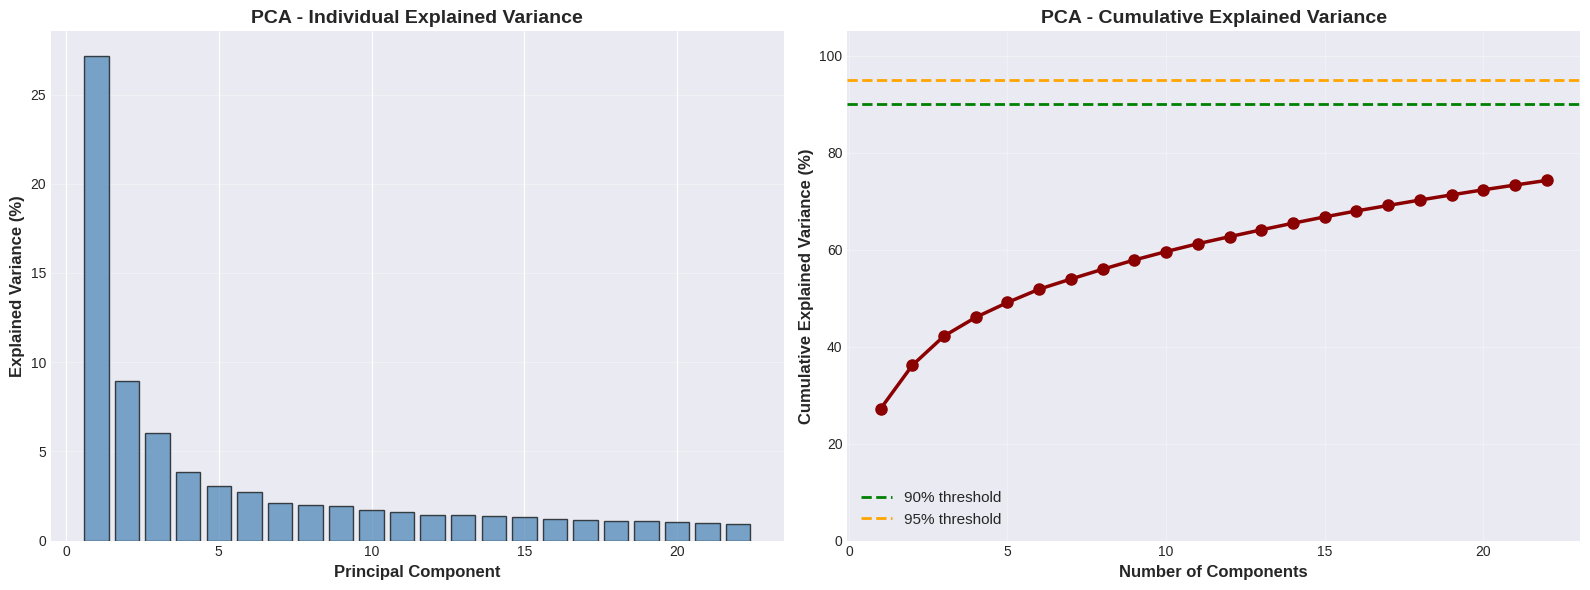

First 10 PCs explain: 59.59% of variance
All 22 PCs explain: 74.26% of variance


In [45]:
# Visualize PCA explained variance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Individual and cumulative explained variance
axes[0].bar(range(1, n_components+1), pca.explained_variance_ratio_ * 100,
           alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Explained Variance (%)', fontsize=12, fontweight='bold')
axes[0].set_title('PCA - Individual Explained Variance', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Cumulative explained variance
cumsum = np.cumsum(pca.explained_variance_ratio_) * 100
axes[1].plot(range(1, n_components+1), cumsum, 'o-', linewidth=2.5,
            markersize=8, color='darkred')
axes[1].axhline(y=90, color='green', linestyle='--', linewidth=2, label='90% threshold')
axes[1].axhline(y=95, color='orange', linestyle='--', linewidth=2, label='95% threshold')
axes[1].set_xlabel('Number of Components', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cumulative Explained Variance (%)', fontsize=12, fontweight='bold')
axes[1].set_title('PCA - Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 105])

plt.tight_layout()
plt.show()

print(f"First 10 PCs explain: {cumsum[9]:.2f}% of variance")
print(f"All {n_components} PCs explain: {cumsum[-1]:.2f}% of variance")

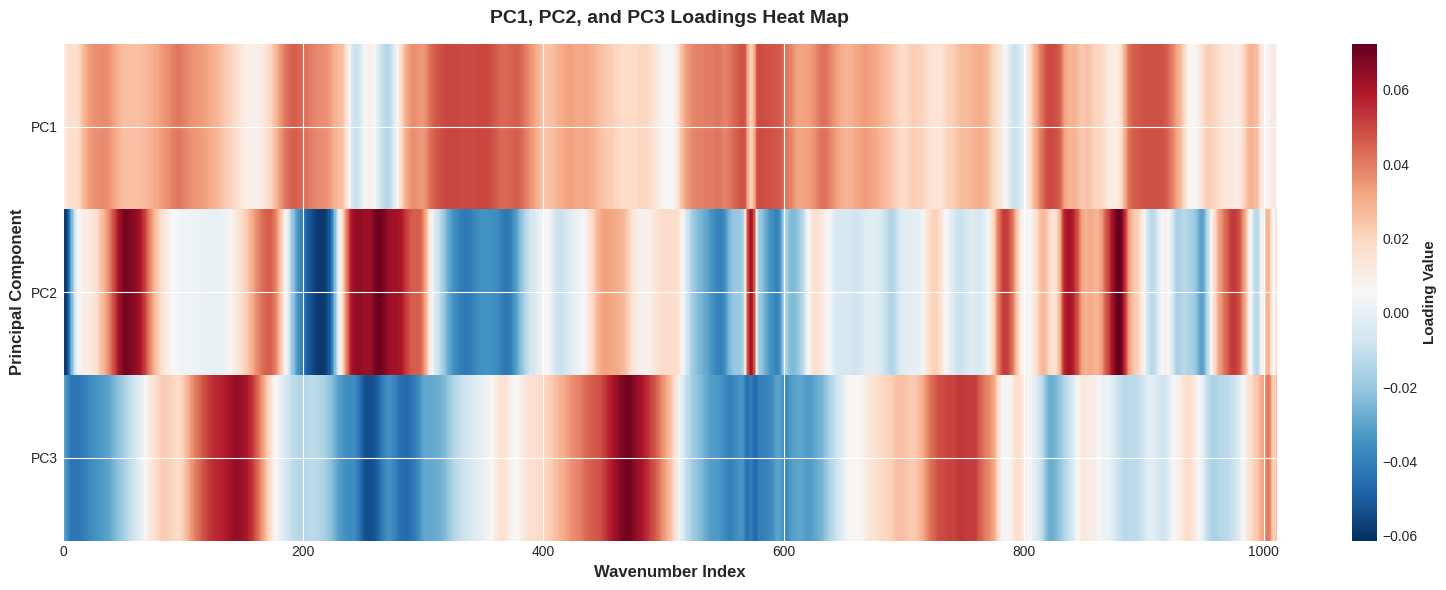

In [46]:
# Plot first 3 principal components as heatmap (as in the paper)
fig, ax = plt.subplots(figsize=(16, 6))

# Create heatmap of PC loadings
pc_loadings = pca.components_[:3, :]
im = ax.imshow(pc_loadings, cmap='RdBu_r', aspect='auto', interpolation='nearest')

ax.set_xlabel('Wavenumber Index', fontsize=12, fontweight='bold')
ax.set_ylabel('Principal Component', fontsize=12, fontweight='bold')
ax.set_title('PC1, PC2, and PC3 Loadings Heat Map', fontsize=14, fontweight='bold', pad=15)
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['PC1', 'PC2', 'PC3'])

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Loading Value', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. t-SNE Visualization (Unsupervised)

Verify that concentration classes are separable in lower-dimensional space

In [47]:
# t-SNE visualization (using subset for computational efficiency)
print("Computing t-SNE embeddings...")
print("(Using subset of 5000 spectra for faster computation)\n")

# Sample subset stratified by class
sample_size_per_class = 500
indices = []
for class_idx in range(len(cr_concentrations)):
    class_indices = np.where(y == class_idx)[0]
    if len(class_indices) > sample_size_per_class:
        sampled = np.random.choice(class_indices, sample_size_per_class, replace=False)
    else:
        sampled = class_indices
    indices.extend(sampled)

indices = np.array(indices)
X_pca_subset = X_pca[indices]
y_subset = y[indices]

# Compute t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_pca_subset)

print("✓ t-SNE computation complete!")
print(f"  Embedded {len(X_tsne)} samples into 2D")

Computing t-SNE embeddings...
(Using subset of 5000 spectra for faster computation)

✓ t-SNE computation complete!
  Embedded 5000 samples into 2D


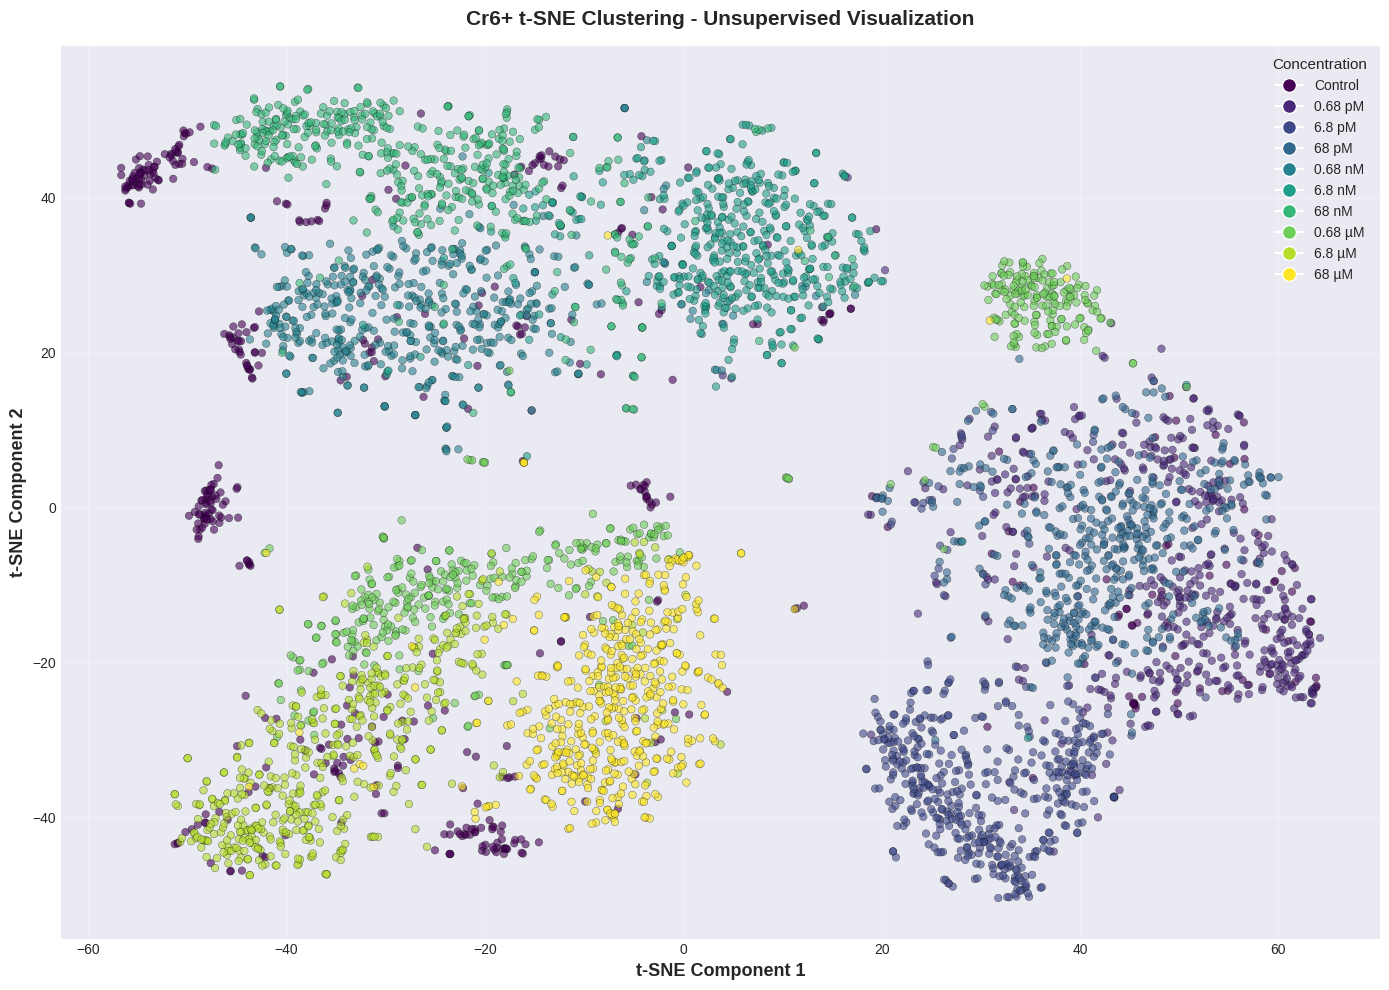

In [48]:
# Plot t-SNE visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Create scatter plot with color-coded classes
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1],
                    c=y_subset, cmap='viridis',
                    alpha=0.6, s=30, edgecolors='black', linewidth=0.3)

ax.set_xlabel('t-SNE Component 1', fontsize=13, fontweight='bold')
ax.set_ylabel('t-SNE Component 2', fontsize=13, fontweight='bold')
ax.set_title('Cr6+ t-SNE Clustering - Unsupervised Visualization',
            fontsize=15, fontweight='bold', pad=15)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w',
                         markerfacecolor=plt.cm.viridis(i/9),
                         markersize=10, label=conc)
                  for i, conc in enumerate(cr_concentrations)]
ax.legend(handles=legend_elements, loc='best', fontsize=10,
         title='Concentration', title_fontsize=11)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Train-Test Split and SMOTE

- 80% training, 20% testing
- Apply SMOTE to balance classes in training set

In [49]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Original dataset split:")
print(f"  Training set: {X_train.shape[0]:,} samples")
print(f"  Test set: {X_test.shape[0]:,} samples")
print(f"\nClass distribution in training set (before SMOTE):")
for i, conc in enumerate(cr_concentrations):
    count = np.sum(y_train == i)
    print(f"  {conc:15s}: {count:5d} samples")

Original dataset split:
  Training set: 15,040 samples
  Test set: 3,760 samples

Class distribution in training set (before SMOTE):
  Control        :  6400 samples
  0.68 pM        :   960 samples
  6.8 pM         :   960 samples
  68 pM          :   960 samples
  0.68 nM        :   960 samples
  6.8 nM         :   960 samples
  68 nM          :   960 samples
  0.68 µM        :   960 samples
  6.8 µM         :   960 samples
  68 µM          :   960 samples


In [50]:
# Apply SMOTE to balance classes
print("\nApplying SMOTE to balance classes...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\n✓ SMOTE complete!")
print(f"  Training set after SMOTE: {X_train_smote.shape[0]:,} samples")
print(f"\nClass distribution in training set (after SMOTE):")
for i, conc in enumerate(cr_concentrations):
    count = np.sum(y_train_smote == i)
    print(f"  {conc:15s}: {count:5d} samples")


Applying SMOTE to balance classes...

✓ SMOTE complete!
  Training set after SMOTE: 64,000 samples

Class distribution in training set (after SMOTE):
  Control        :  6400 samples
  0.68 pM        :  6400 samples
  6.8 pM         :  6400 samples
  68 pM          :  6400 samples
  0.68 nM        :  6400 samples
  6.8 nM         :  6400 samples
  68 nM          :  6400 samples
  0.68 µM        :  6400 samples
  6.8 µM         :  6400 samples
  68 µM          :  6400 samples


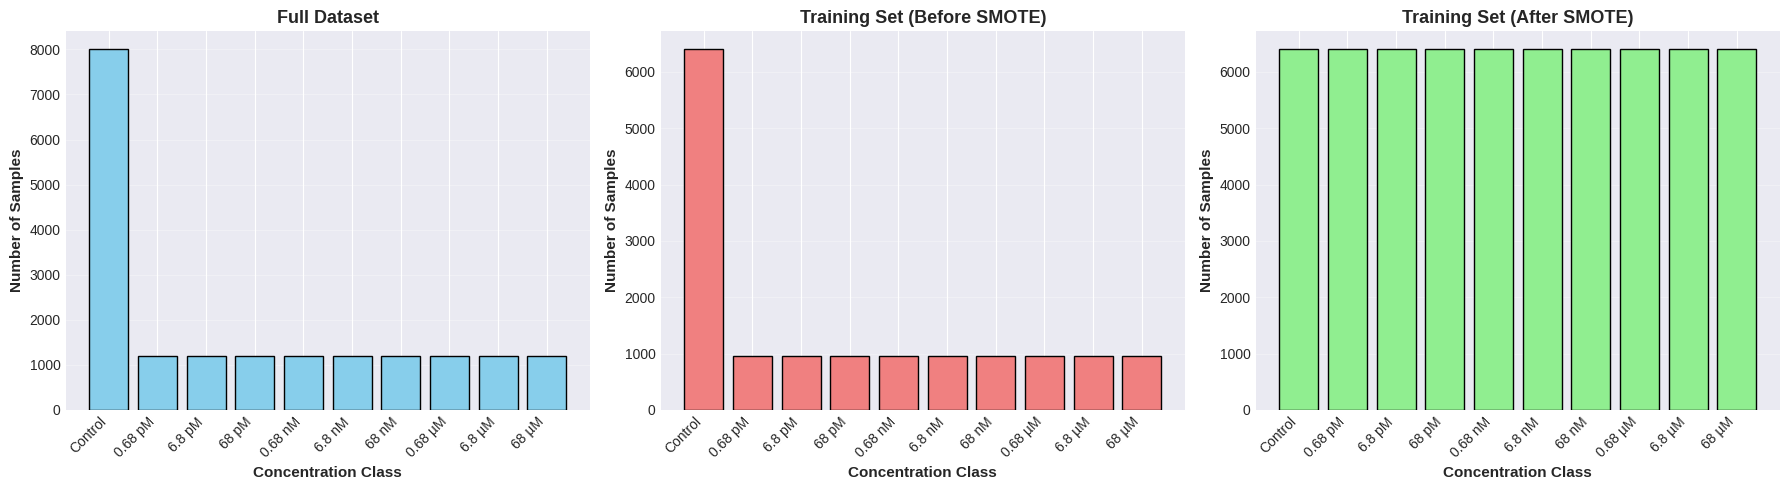

In [51]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Before split
class_counts = [np.sum(y == i) for i in range(len(cr_concentrations))]
axes[0].bar(range(len(cr_concentrations)), class_counts, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Concentration Class', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
axes[0].set_title('Full Dataset', fontsize=13, fontweight='bold')
axes[0].set_xticks(range(len(cr_concentrations)))
axes[0].set_xticklabels(cr_concentrations, rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# Training set before SMOTE
train_counts = [np.sum(y_train == i) for i in range(len(cr_concentrations))]
axes[1].bar(range(len(cr_concentrations)), train_counts, color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Concentration Class', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
axes[1].set_title('Training Set (Before SMOTE)', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(len(cr_concentrations)))
axes[1].set_xticklabels(cr_concentrations, rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

# Training set after SMOTE
smote_counts = [np.sum(y_train_smote == i) for i in range(len(cr_concentrations))]
axes[2].bar(range(len(cr_concentrations)), smote_counts, color='lightgreen', edgecolor='black')
axes[2].set_xlabel('Concentration Class', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
axes[2].set_title('Training Set (After SMOTE)', fontsize=13, fontweight='bold')
axes[2].set_xticks(range(len(cr_concentrations)))
axes[2].set_xticklabels(cr_concentrations, rotation=45, ha='right')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Support Vector Machine (SVM) Classification

In [52]:
# Train SVM classifier
print("Training SVM classifier with RBF kernel...\n")

svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_smote, y_train_smote)

print("✓ SVM training complete!")

# Predict on test set
y_pred_svm = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm, average='weighted')

print(f"\n{'='*60}")
print(f"SVM CLASSIFICATION RESULTS")
print(f"{'='*60}")
print(f"Test Accuracy: {svm_accuracy*100:.2f}%")
print(f"Weighted F1-Score: {svm_f1:.4f}")
print(f"{'='*60}")

Training SVM classifier with RBF kernel...

✓ SVM training complete!

SVM CLASSIFICATION RESULTS
Test Accuracy: 83.70%
Weighted F1-Score: 0.8396


In [53]:
# Detailed classification report
print("\nDetailed Classification Report (SVM):\n")
print(classification_report(y_test, y_pred_svm,
                           target_names=cr_concentrations,
                           digits=4,
                           zero_division=0))


Detailed Classification Report (SVM):

              precision    recall  f1-score   support

     Control     0.9376    0.7512    0.8341      1600
     0.68 pM     0.6025    0.7958    0.6858       240
      6.8 pM     0.9623    0.9583    0.9603       240
       68 pM     0.8361    0.8292    0.8326       240
     0.68 nM     0.7418    0.9458    0.8315       240
      6.8 nM     0.8819    0.8708    0.8763       240
       68 nM     0.8315    0.9250    0.8757       240
     0.68 µM     0.8755    0.9375    0.9054       240
      6.8 µM     0.6177    0.9292    0.7421       240
       68 µM     0.8555    0.9125    0.8831       240

    accuracy                         0.8370      3760
   macro avg     0.8142    0.8855    0.8427      3760
weighted avg     0.8589    0.8370    0.8396      3760



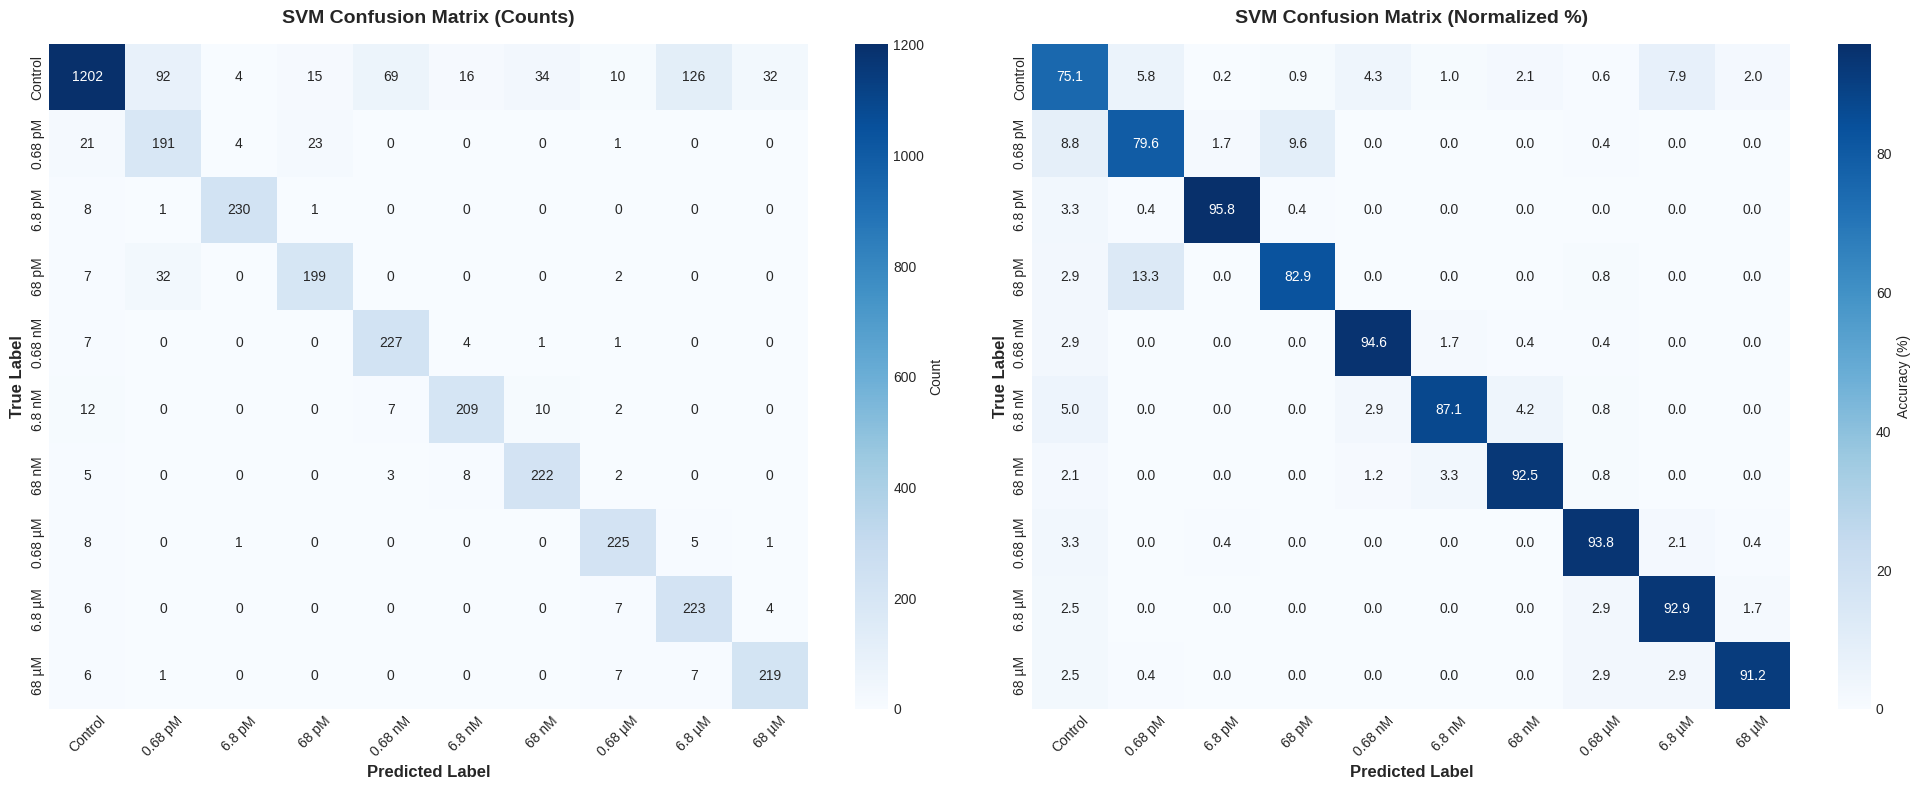

In [54]:
# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_svm_normalized = cm_svm.astype('float') / cm_svm.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Absolute counts
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cr_concentrations, yticklabels=cr_concentrations,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_title('SVM Confusion Matrix (Counts)', fontsize=14, fontweight='bold', pad=15)
axes[0].tick_params(axis='x', rotation=45)

# Normalized percentages
sns.heatmap(cm_svm_normalized, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=cr_concentrations, yticklabels=cr_concentrations,
            ax=axes[1], cbar_kws={'label': 'Accuracy (%)'})
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_title('SVM Confusion Matrix (Normalized %)', fontsize=14, fontweight='bold', pad=15)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 7. Random Forest Classification

In [55]:
# Train Random Forest
print("Training Random Forest classifier...\n")

rf_model = RandomForestClassifier(n_estimators=200, max_depth=25,
                                 random_state=42, n_jobs=-1)
rf_model.fit(X_train_smote, y_train_smote)

print("✓ Random Forest training complete!")

# Predict
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print(f"\nRandom Forest Results:")
print(f"  Test Accuracy: {rf_accuracy*100:.2f}%")
print(f"  Weighted F1-Score: {rf_f1:.4f}")

Training Random Forest classifier...

✓ Random Forest training complete!

Random Forest Results:
  Test Accuracy: 83.67%
  Weighted F1-Score: 0.8403


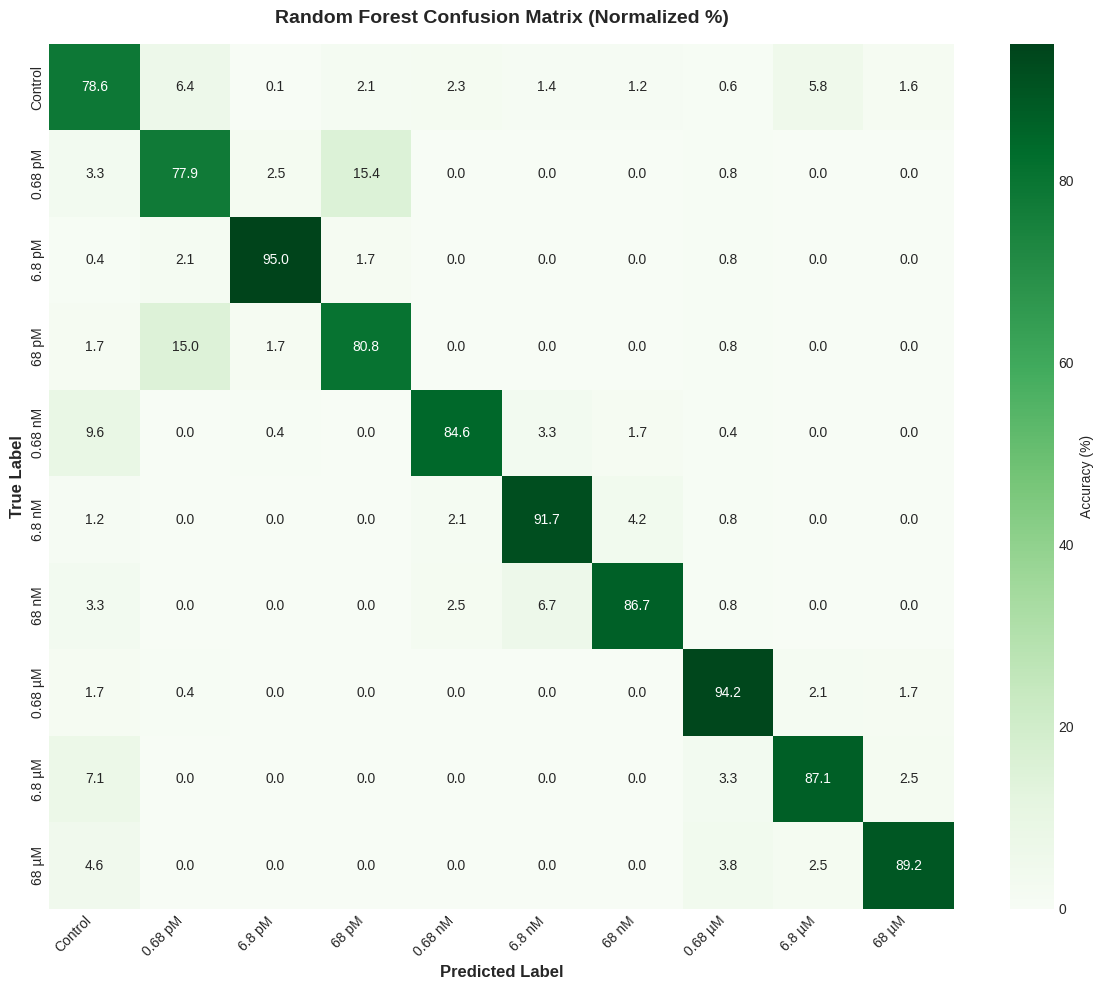

In [56]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf_normalized = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis] * 100

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm_rf_normalized, annot=True, fmt='.1f', cmap='Greens',
            xticklabels=cr_concentrations, yticklabels=cr_concentrations,
            ax=ax, cbar_kws={'label': 'Accuracy (%)'})
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Random Forest Confusion Matrix (Normalized %)',
            fontsize=14, fontweight='bold', pad=15)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 8. Gradient Boosting Classification

In [57]:
# Train Gradient Boosting with improved hyperparameters
print("Training Gradient Boosting classifier...\n")

gb_model = GradientBoostingClassifier(
    n_estimators=300,          # More estimators for better learning
    max_depth=4,               # Slightly shallower to reduce overfitting
    learning_rate=0.05,        # Lower rate with more estimators
    min_samples_split=5,       # Prevent overfitting on small nodes
    min_samples_leaf=2,        # Minimum samples in leaf
    subsample=0.8,             # Stochastic gradient boosting
    max_features='sqrt',       # Use sqrt of features for each split
    random_state=42,
    verbose=1                  # Show progress
)
gb_model.fit(X_train_smote, y_train_smote)

print("\nGradient Boosting training complete!")

# Predict
y_pred_gb = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred_gb)
gb_f1 = f1_score(y_test, y_pred_gb, average='weighted')

print(f"\n{'='*60}")
print(f"GRADIENT BOOSTING RESULTS")
print(f"{'='*60}")
print(f"Test Accuracy: {gb_accuracy*100:.2f}%")
print(f"Weighted F1-Score: {gb_f1:.4f}")
print(f"{'='*60}")

Training Gradient Boosting classifier...

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           2.1348           0.1654           12.16m
         2           1.9908           0.1445           12.19m
         3           1.8701           0.1217           12.92m
         4           1.7452           0.1240           13.23m
         5           1.6493           0.0932           12.88m
         6           1.5589           0.0902           12.67m
         7           1.4776           0.0863           12.46m
         8           1.4036           0.0716           12.46m
         9           1.3405           0.0670           12.75m
        10           1.2864           0.0498           12.58m
        20           0.8889           0.0336           12.09m
        30           0.6729           0.0165           11.61m
        40           0.5477           0.0153           11.15m
        50           0.4622           0.0077           10.77m
        60           0.4036

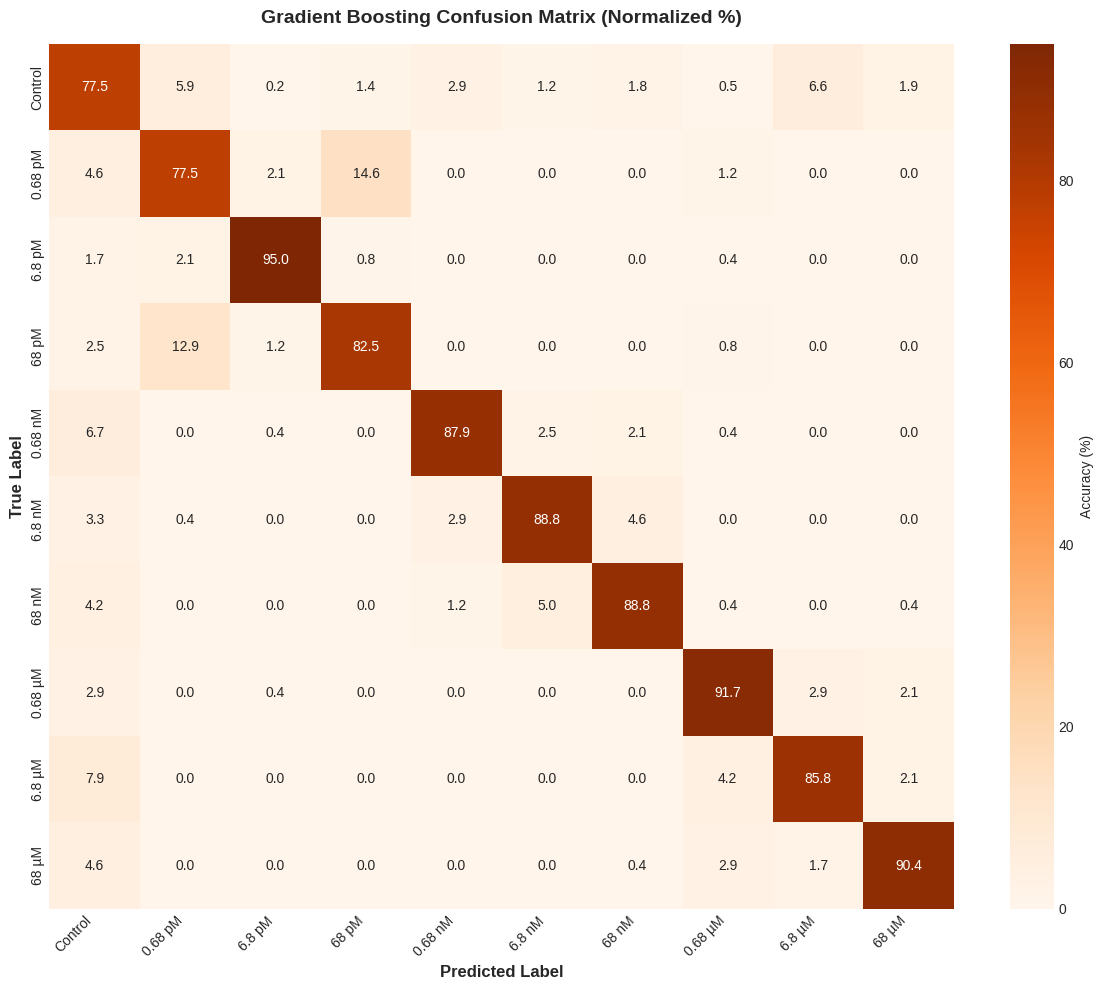

In [58]:
  # Confusion Matrix for Gradient Boosting
cm_gb = confusion_matrix(y_test, y_pred_gb)
cm_gb_normalized = cm_gb.astype('float') / cm_gb.sum(axis=1)[:, np.newaxis] * 100

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm_gb_normalized, annot=True, fmt='.1f', cmap='Oranges',
            xticklabels=cr_concentrations, yticklabels=cr_concentrations,
            ax=ax, cbar_kws={'label': 'Accuracy (%)'})
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Gradient Boosting Confusion Matrix (Normalized %)',
            fontsize=14, fontweight='bold', pad=15)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 9. K-Nearest Neighbors (KNN) Classification

In [59]:
# Train KNN
print("Training K-Nearest Neighbors classifier...\n")

knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_model.fit(X_train_smote, y_train_smote)

print("✓ KNN training complete!")

# Predict
y_pred_knn = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn, average='weighted')

print(f"\nKNN Results:")
print(f"  Test Accuracy: {knn_accuracy*100:.2f}%")
print(f"  Weighted F1-Score: {knn_f1:.4f}")

Training K-Nearest Neighbors classifier...

✓ KNN training complete!

KNN Results:
  Test Accuracy: 83.91%
  Weighted F1-Score: 0.8418


## 10. Logistic Regression Classification

In [60]:
# Train Logistic Regression
print("Training Logistic Regression classifier...\n")

lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(X_train_smote, y_train_smote)

print("✓ Logistic Regression training complete!")

# Predict
y_pred_lr = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr, average='weighted')

print(f"\nLogistic Regression Results:")
print(f"  Test Accuracy: {lr_accuracy*100:.2f}%")
print(f"  Weighted F1-Score: {lr_f1:.4f}")

Training Logistic Regression classifier...

✓ Logistic Regression training complete!

Logistic Regression Results:
  Test Accuracy: 73.46%
  Weighted F1-Score: 0.7337


## 11. Cross-Validation Analysis

In [63]:
# # 10-fold cross-validation for SVM
# print("Performing 10-fold cross-validation...\n")

# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# print("SVM Cross-Validation:")
# cv_scores_svm = cross_val_score(svm_model, X_train_smote, y_train_smote,
#                                 cv=cv, n_jobs=-1, scoring='accuracy')
# print(f"  Fold scores: {cv_scores_svm}")
# print(f"  Mean CV Accuracy: {cv_scores_svm.mean()*100:.2f}% (+/- {cv_scores_svm.std()*100:.2f}%)")

# print("\nRandom Forest Cross-Validation:")
# cv_scores_rf = cross_val_score(rf_model, X_train_smote, y_train_smote,
#                                cv=cv, n_jobs=-1, scoring='accuracy')
# print(f"  Fold scores: {cv_scores_rf}")
# print(f"  Mean CV Accuracy: {cv_scores_rf.mean()*100:.2f}% (+/- {cv_scores_rf.std()*100:.2f}%)")

# 10-fold cross-validation for all models
print("Performing 5-fold cross-validation for all models...\n")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results for comparison
cv_results = {}

# SVM
print("1. SVM Cross-Validation:")
cv_scores_svm = cross_val_score(svm_model, X_train_smote, y_train_smote,
                                cv=cv, n_jobs=-1, scoring='accuracy')
cv_results['SVM'] = cv_scores_svm
print(f"   Mean CV Accuracy: {cv_scores_svm.mean()*100:.2f}% (+/- {cv_scores_svm.std()*100:.2f}%)")

# Random Forest
print("\n2. Random Forest Cross-Validation:")
cv_scores_rf = cross_val_score(rf_model, X_train_smote, y_train_smote,
                               cv=cv, n_jobs=-1, scoring='accuracy')
cv_results['Random Forest'] = cv_scores_rf
print(f"   Mean CV Accuracy: {cv_scores_rf.mean()*100:.2f}% (+/- {cv_scores_rf.std()*100:.2f}%)")

# Gradient Boosting
# print("\n3. Gradient Boosting Cross-Validation:")
# cv_scores_gb = cross_val_score(gb_model, X_train_smote, y_train_smote,
#                                cv=cv, n_jobs=-1, scoring='accuracy')
# cv_results['Gradient Boosting'] = cv_scores_gb
# print(f"   Mean CV Accuracy: {cv_scores_gb.mean()*100:.2f}% (+/- {cv_scores_gb.std()*100:.2f}%)")

# KNN
print("\n4. KNN Cross-Validation:")
cv_scores_knn = cross_val_score(knn_model, X_train_smote, y_train_smote,
                                cv=cv, n_jobs=-1, scoring='accuracy')
cv_results['KNN'] = cv_scores_knn
print(f"   Mean CV Accuracy: {cv_scores_knn.mean()*100:.2f}% (+/- {cv_scores_knn.std()*100:.2f}%)")

# Logistic Regression
print("\n5. Logistic Regression Cross-Validation:")
cv_scores_lr = cross_val_score(lr_model, X_train_smote, y_train_smote,
                               cv=cv, n_jobs=-1, scoring='accuracy')
cv_results['Logistic Regression'] = cv_scores_lr
print(f"   Mean CV Accuracy: {cv_scores_lr.mean()*100:.2f}% (+/- {cv_scores_lr.std()*100:.2f}%)")

# Summary table
print(f"\n{'='*70}")
print("CROSS-VALIDATION SUMMARY")
print(f"{'='*70}")
print(f"{'Model':<25} {'Mean Accuracy':<18} {'Std Dev':<12}")
print(f"{'-'*70}")
for name, scores in cv_results.items():
    print(f"{name:<25} {scores.mean()*100:>6.2f}%           +/- {scores.std()*100:.2f}%")
print(f"{'='*70}")

Performing 5-fold cross-validation for all models...

1. SVM Cross-Validation:
   Mean CV Accuracy: 94.50% (+/- 0.18%)

2. Random Forest Cross-Validation:
   Mean CV Accuracy: 96.75% (+/- 0.09%)

4. KNN Cross-Validation:
   Mean CV Accuracy: 96.73% (+/- 0.12%)

5. Logistic Regression Cross-Validation:
   Mean CV Accuracy: 87.00% (+/- 0.18%)

CROSS-VALIDATION SUMMARY
Model                     Mean Accuracy      Std Dev     
----------------------------------------------------------------------
SVM                        94.50%           +/- 0.18%
Random Forest              96.75%           +/- 0.09%
KNN                        96.73%           +/- 0.12%
Logistic Regression        87.00%           +/- 0.18%


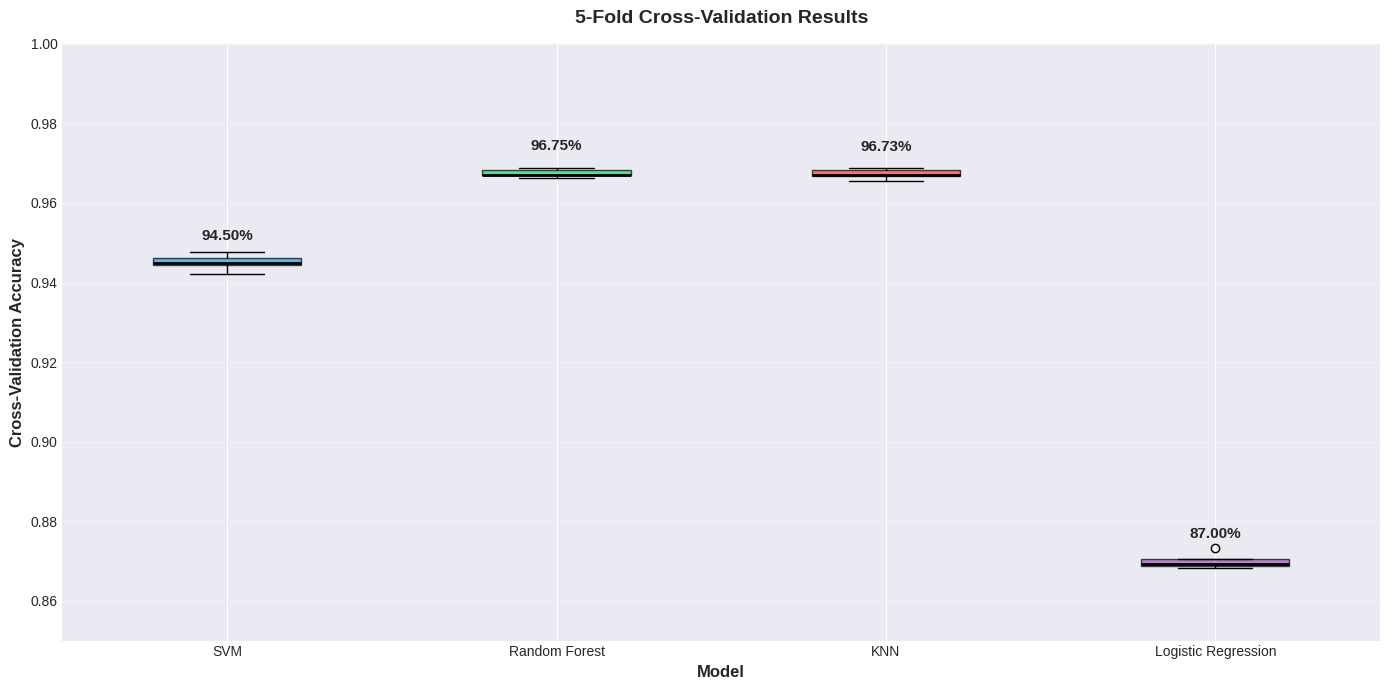

In [64]:
# Visualize cross-validation results
fig, ax = plt.subplots(figsize=(14, 7))

models = ['SVM', 'Random Forest', 'KNN', 'Logistic Regression']
cv_results_list = [cv_scores_svm, cv_scores_rf, cv_scores_knn, cv_scores_lr]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

bp = ax.boxplot(cv_results_list, labels=models, patch_artist=True,
               medianprops=dict(color='black', linewidth=2),
               whiskerprops=dict(color='black'),
               capprops=dict(color='black'))

# Color each box differently
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Cross-Validation Accuracy', fontsize=12, fontweight='bold')
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_title('5-Fold Cross-Validation Results', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.85, 1.0])

# Add mean values
for i, scores in enumerate(cv_results_list, 1):
    ax.text(i, scores.mean() + 0.005, f'{scores.mean()*100:.2f}%',
           ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

## 12. Model Comparison Summary

In [67]:
# Create comprehensive comparison
results_df = pd.DataFrame({
    'Model': ['SVM (RBF)', 'Random Forest', 'Gradient Boosting', 'KNN', 'Logistic Regression'],
    'Test Accuracy (%)': [
        svm_accuracy * 100,
        rf_accuracy * 100,
        gb_accuracy * 100,
        knn_accuracy * 100,
        lr_accuracy * 100
    ],
    'F1-Score': [svm_f1, rf_f1, gb_f1, knn_f1, lr_f1]
})

# Sort by accuracy
results_df = results_df.sort_values('Test Accuracy (%)', ascending=False).reset_index(drop=True)

print("\n" + "="*70)
print(" "*20 + "MODEL COMPARISON SUMMARY")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)
print(f"\nBest Model: {results_df.iloc[0]['Model']}")
print(f"Best Accuracy: {results_df.iloc[0]['Test Accuracy (%)']:.2f}%")
print("="*70)


                    MODEL COMPARISON SUMMARY
              Model  Test Accuracy (%)  F1-Score
                KNN          83.909574  0.841782
          SVM (RBF)          83.696809  0.839610
      Random Forest          83.670213  0.840292
  Gradient Boosting          83.297872  0.836002
Logistic Regression          73.457447  0.733688

Best Model: KNN
Best Accuracy: 83.91%


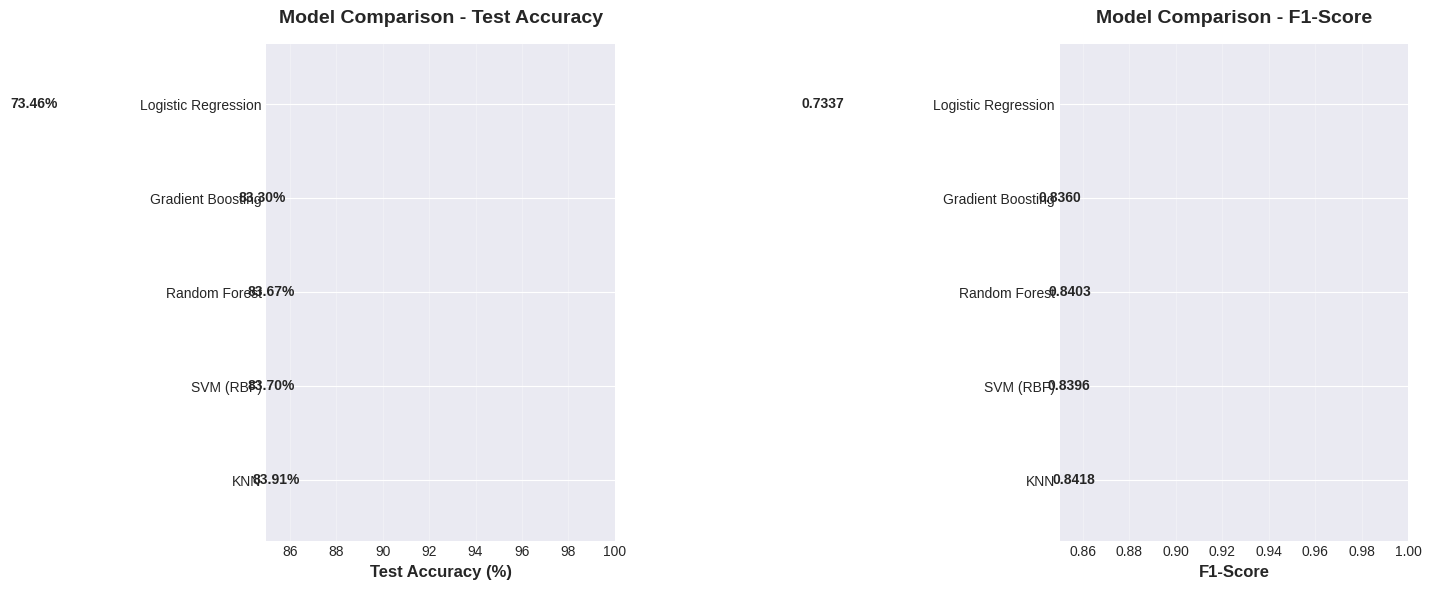

In [68]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define colors for each model (will be applied after sorting)
n_models = len(results_df)
colors_bar = plt.cm.viridis(np.linspace(0.2, 0.8, n_models))

# Accuracy comparison
bars1 = axes[0].barh(results_df['Model'], results_df['Test Accuracy (%)'],
                    color=colors_bar, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Model Comparison - Test Accuracy', fontsize=14, fontweight='bold', pad=15)
axes[0].grid(axis='x', alpha=0.3)
axes[0].set_xlim([85, 100])

# Add value labels
for bar in bars1:
    width = bar.get_width()
    axes[0].text(width + 0.5, bar.get_y() + bar.get_height()/2,
               f'{width:.2f}%', ha='left', va='center',
               fontweight='bold', fontsize=10)

# F1-Score comparison
bars2 = axes[1].barh(results_df['Model'], results_df['F1-Score'],
                    color=colors_bar, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('F1-Score', fontsize=12, fontweight='bold')
axes[1].set_title('Model Comparison - F1-Score', fontsize=14, fontweight='bold', pad=15)
axes[1].grid(axis='x', alpha=0.3)
axes[1].set_xlim([0.85, 1.0])

# Add value labels
for bar in bars2:
    width = bar.get_width()
    axes[1].text(width + 0.005, bar.get_y() + bar.get_height()/2,
               f'{width:.4f}', ha='left', va='center',
               fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

## 13. Per-Class Performance Analysis

In [69]:
# Analyze performance for each concentration class
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred_svm, labels=range(len(cr_concentrations)), zero_division=0
)

per_class_df = pd.DataFrame({
    'Concentration': cr_concentrations,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print(f"\n{'='*70}")
print("PER-CLASS PERFORMANCE (SVM - Best Model)")
print(f"{'='*70}")
print(per_class_df.to_string(index=False))
print(f"{'='*70}")
print(f"\nBest classified:  {cr_concentrations[np.argmax(f1)]} (F1: {np.max(f1):.4f})")
print(f"Worst classified: {cr_concentrations[np.argmin(f1)]} (F1: {np.min(f1):.4f})")


PER-CLASS PERFORMANCE (SVM - Best Model)
Concentration  Precision   Recall  F1-Score  Support
      Control   0.937598 0.751250  0.834143     1600
      0.68 pM   0.602524 0.795833  0.685817      240
       6.8 pM   0.962343 0.958333  0.960334      240
        68 pM   0.836134 0.829167  0.832636      240
      0.68 nM   0.741830 0.945833  0.831502      240
       6.8 nM   0.881857 0.870833  0.876310      240
        68 nM   0.831461 0.925000  0.875740      240
      0.68 µM   0.875486 0.937500  0.905433      240
       6.8 µM   0.617729 0.929167  0.742097      240
        68 µM   0.855469 0.912500  0.883065      240

Best classified:  6.8 pM (F1: 0.9603)
Worst classified: 0.68 pM (F1: 0.6858)


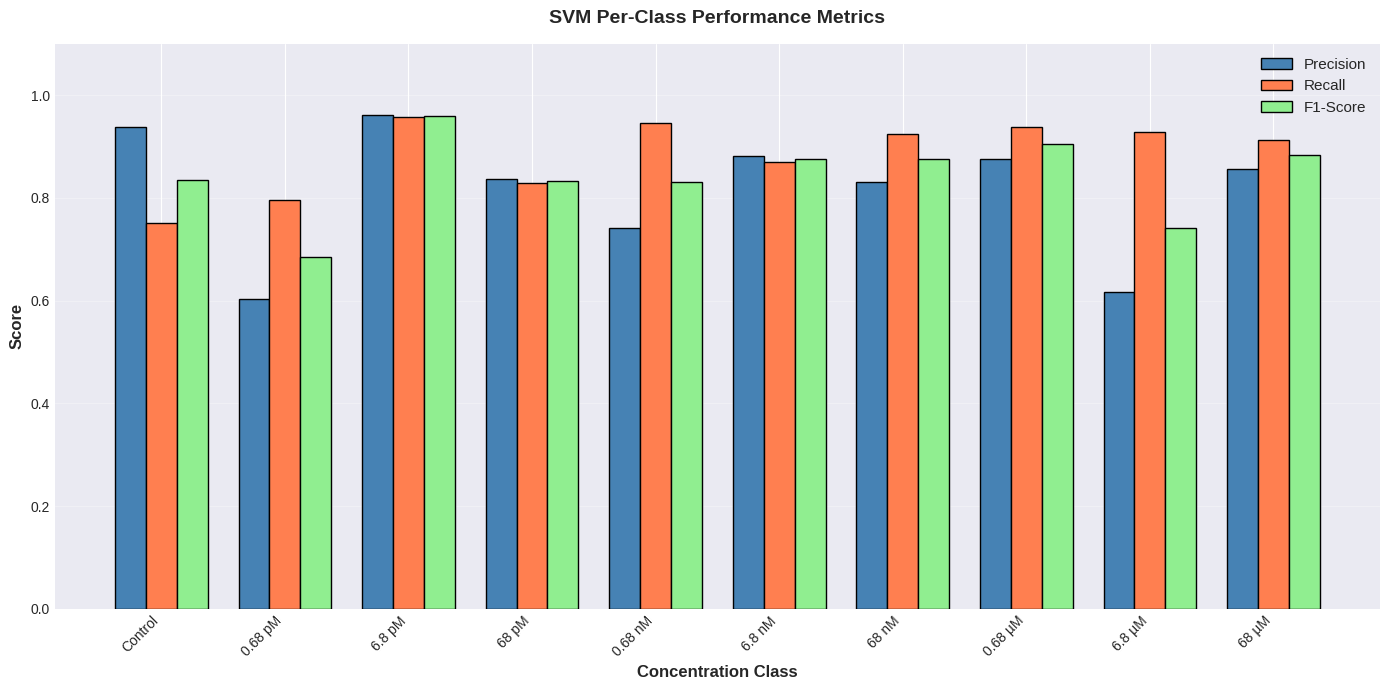

In [70]:
# Visualize per-class performance
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(cr_concentrations))
width = 0.25

bars1 = ax.bar(x - width, per_class_df['Precision'], width,
              label='Precision', color='steelblue', edgecolor='black')
bars2 = ax.bar(x, per_class_df['Recall'], width,
              label='Recall', color='coral', edgecolor='black')
bars3 = ax.bar(x + width, per_class_df['F1-Score'], width,
              label='F1-Score', color='lightgreen', edgecolor='black')

ax.set_xlabel('Concentration Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('SVM Per-Class Performance Metrics', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(cr_concentrations, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()